# Customer Churn Prediction
### Motivation - Predict customer churn to develop focused customer retention programs
### Agenda
- Data Import and Preparation
- Exploratory Data Analysis
- Label Encoding and Feature Scaling
- Model/Metrics Selection
- Model Evaluation

In [63]:
# Import libraries
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_formats = ['retina']
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import auc, precision_recall_curve, roc_curve
import warnings
warnings.filterwarnings("ignore")

# Data Import and Preparation

In [64]:
# Data Source: https://www.kaggle.com/blastchar/telco-customer-churn
df = pd.read_csv('Telco-Customer-Churn.csv',index_col='customerID')
df.TotalCharges.replace(' ',np.nan, inplace=True)
df.TotalCharges = df.TotalCharges.astype('float')
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1:'Yes',0:'No'})
print(f'The data has {df.shape[0]} rows and {df.shape[1]} columns')
print(df.dtypes)
df.head()

The data has 7043 rows and 20 columns
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis

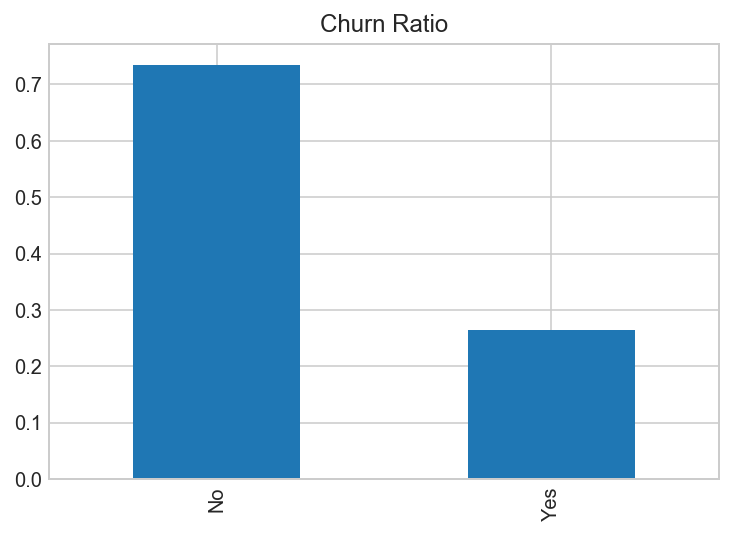

In [65]:
pd.Series(df.Churn.value_counts()/len(df)).plot(kind='bar').set_title('Churn Ratio');

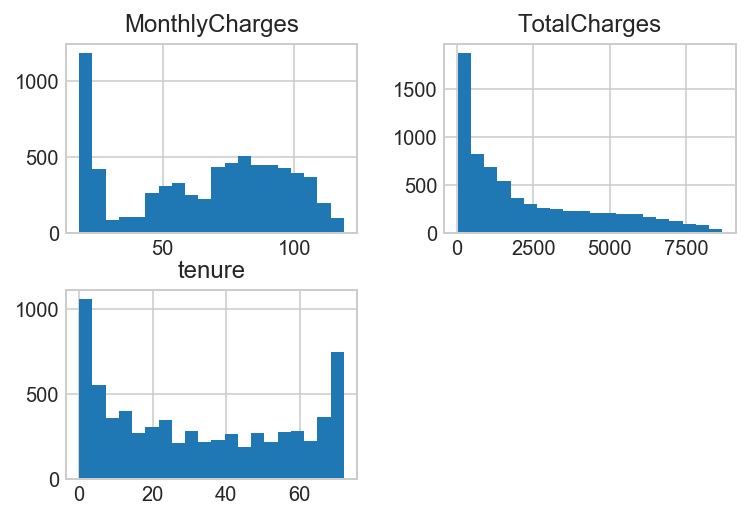

In [66]:
df.hist(bins=20);

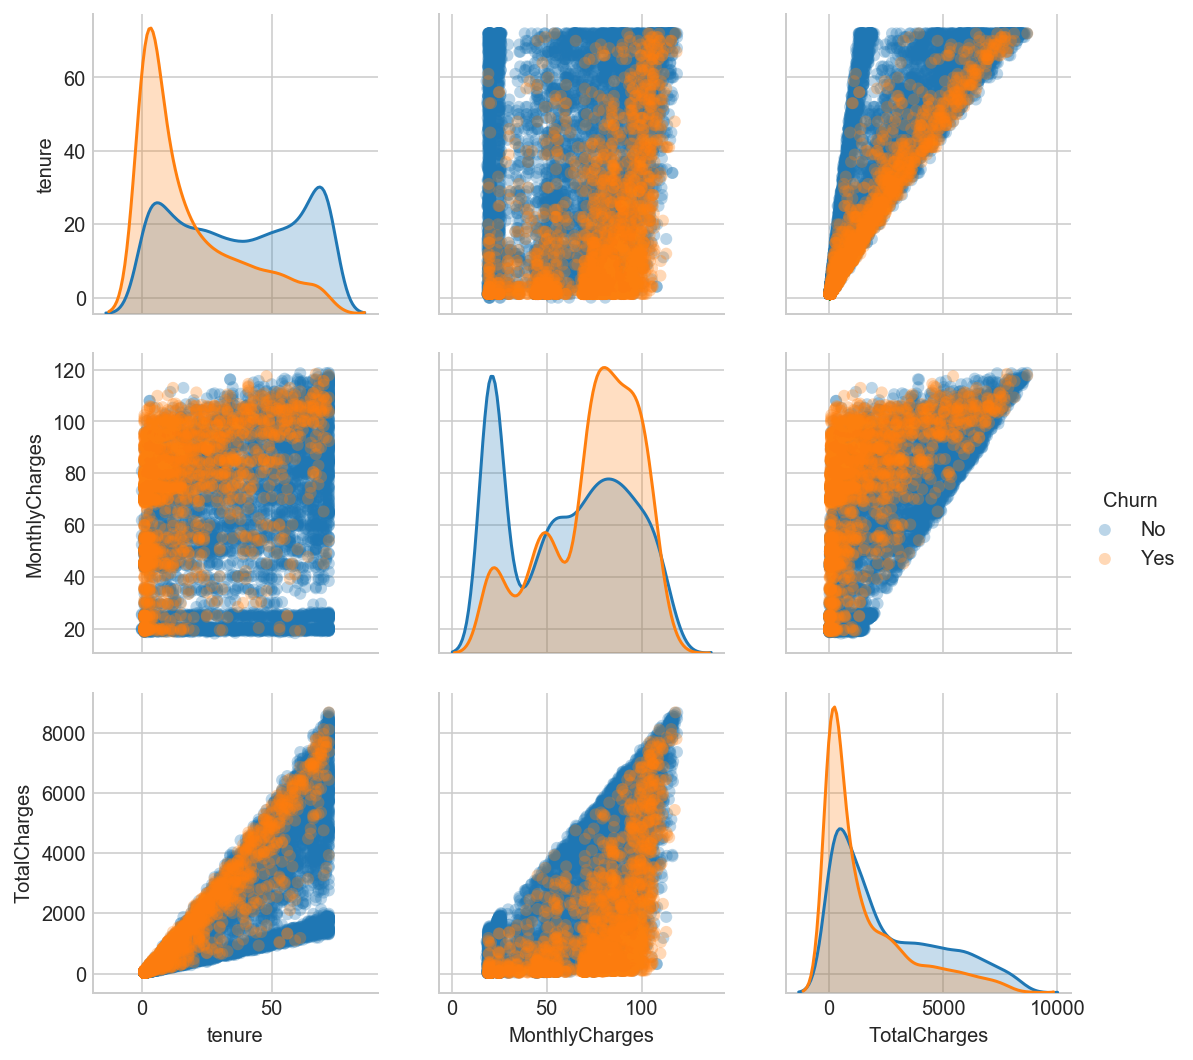

In [67]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], 
             hue='Churn', plot_kws=dict(alpha=.3, edgecolor='none'));

In [68]:
df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.00000,0.247900,0.825880
MonthlyCharges,0.24790,1.000000,0.651065
TotalCharges,0.82588,0.651065,1.000000


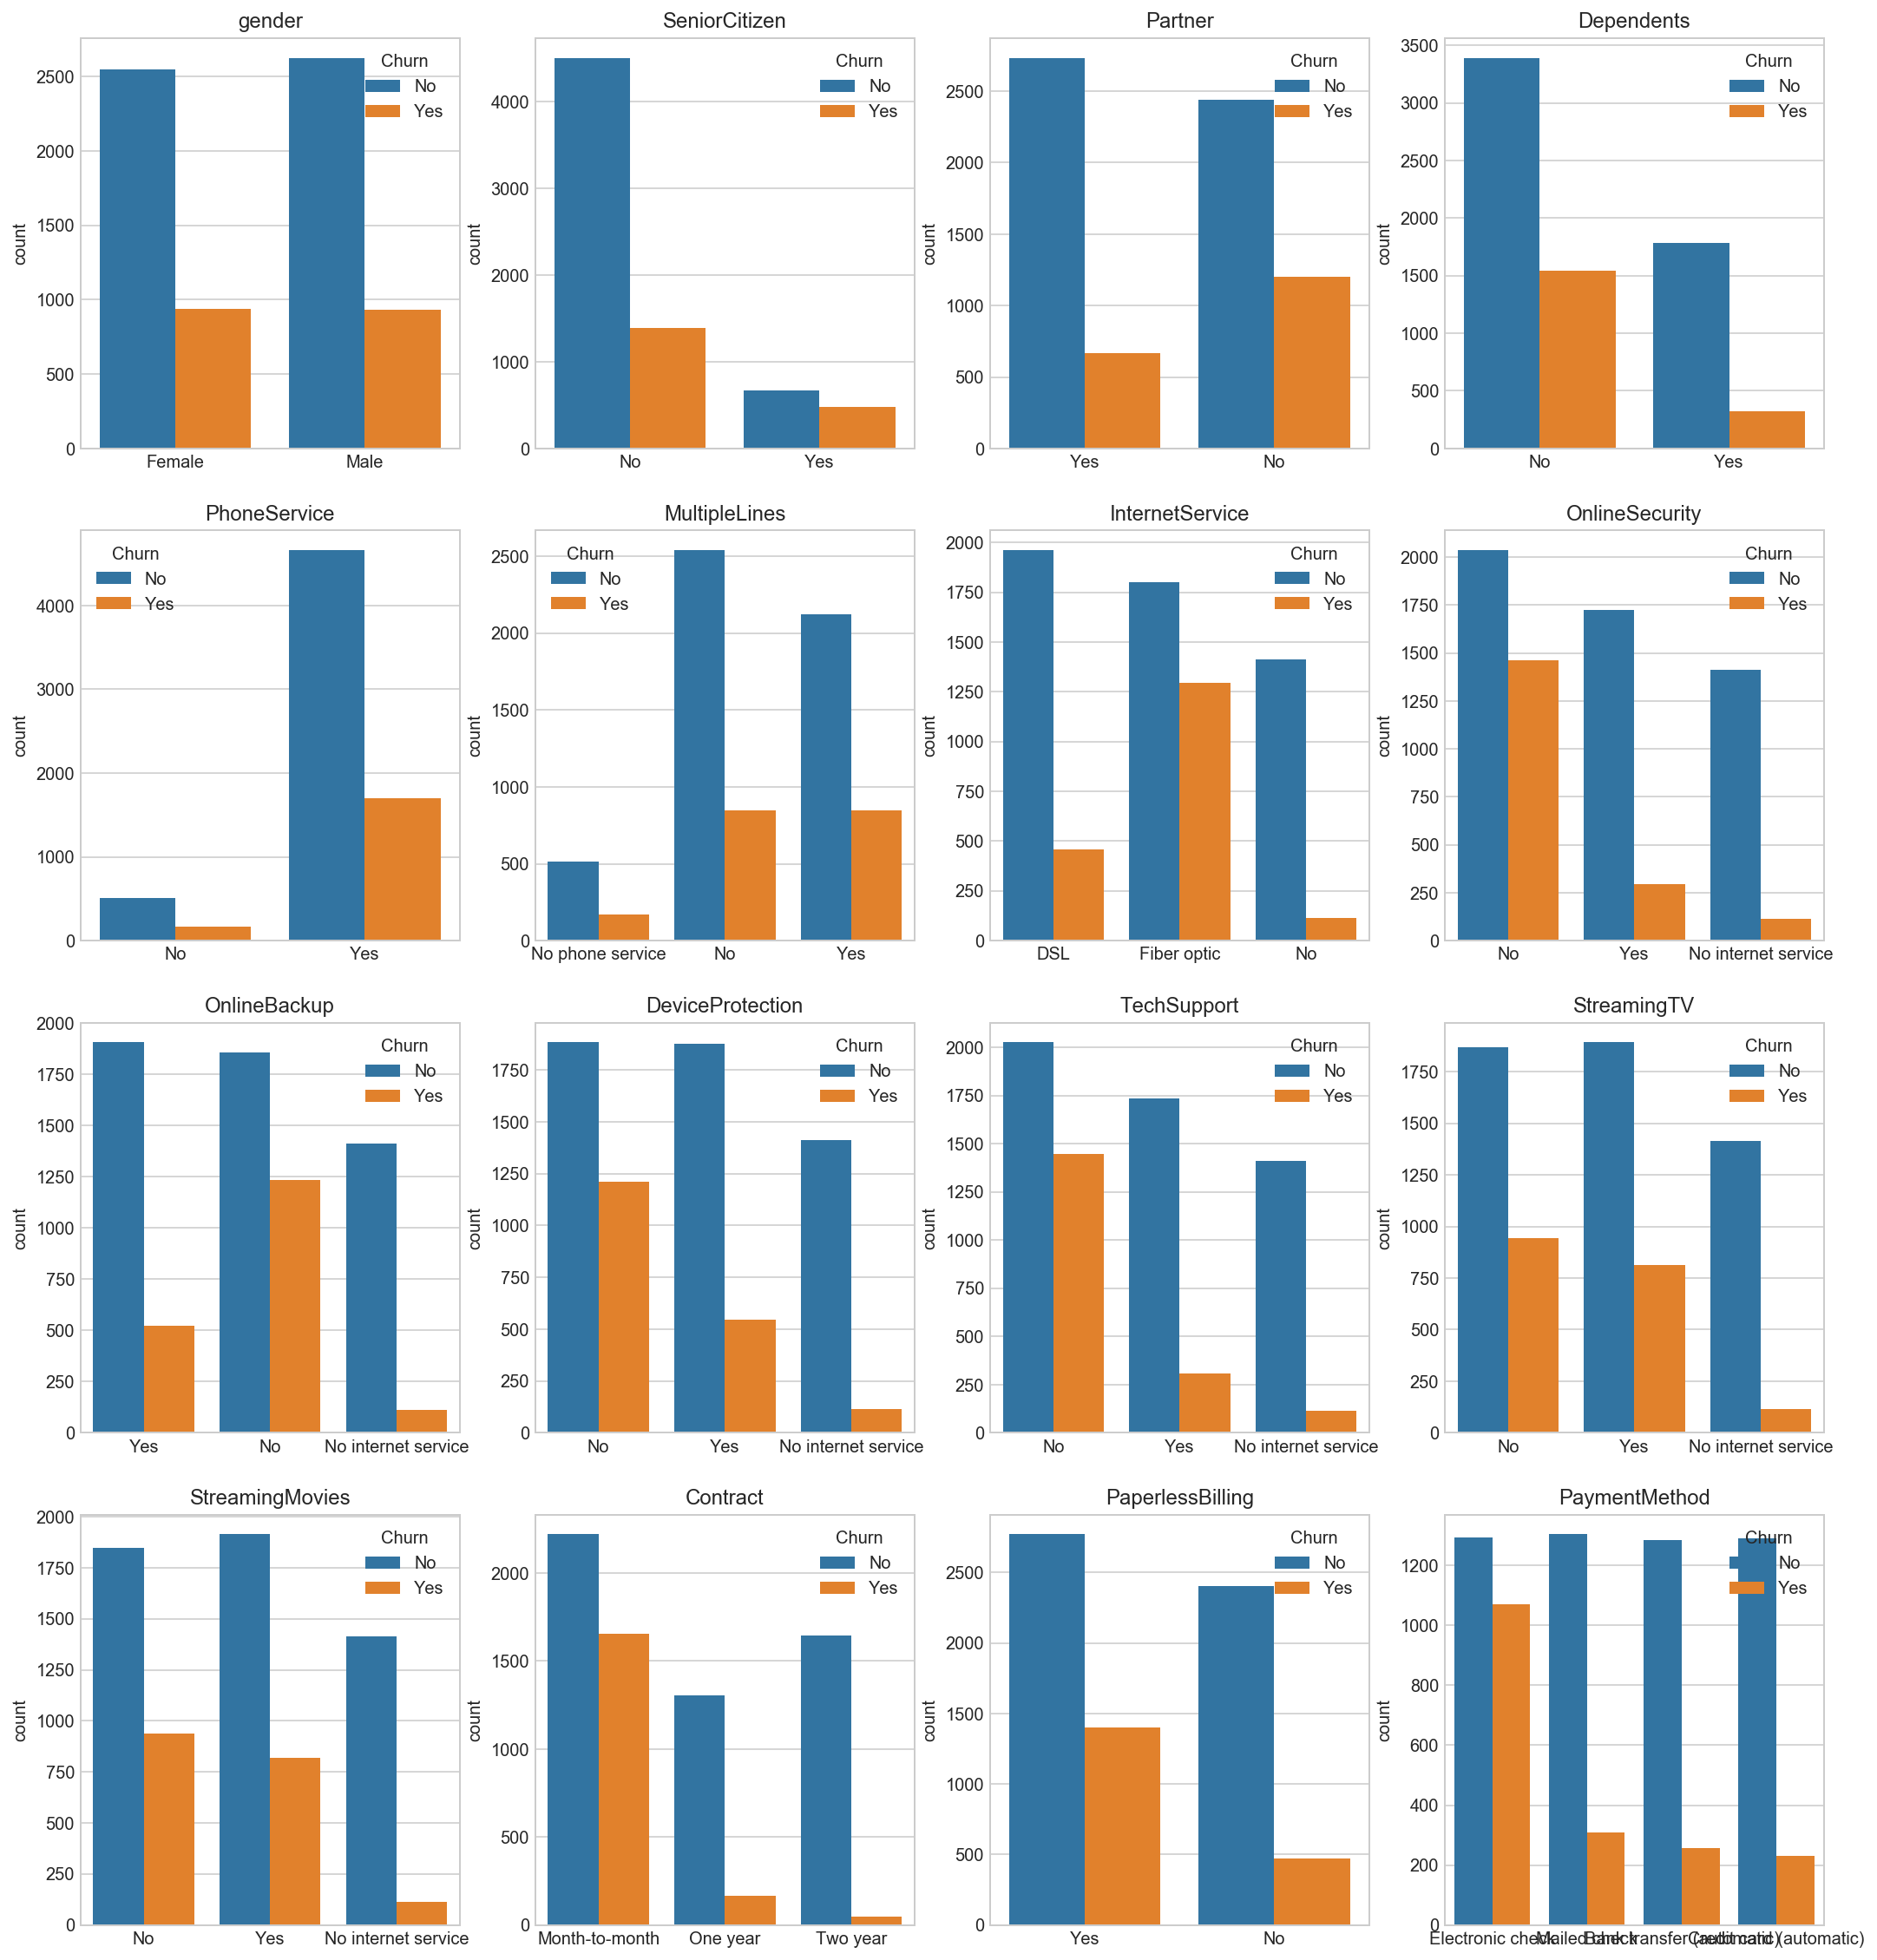

In [69]:
# Plot all the categorical features relative to Churn
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

# The probability/raio of each category to Churn
plt.figure(figsize=(18,20))
for i, col in enumerate(cat_cols):
    
    plt.subplot(4,4,i+1)
    sns.countplot(data=df, x=col, hue='Churn');
    plt.title(col);
    plt.xlabel('');

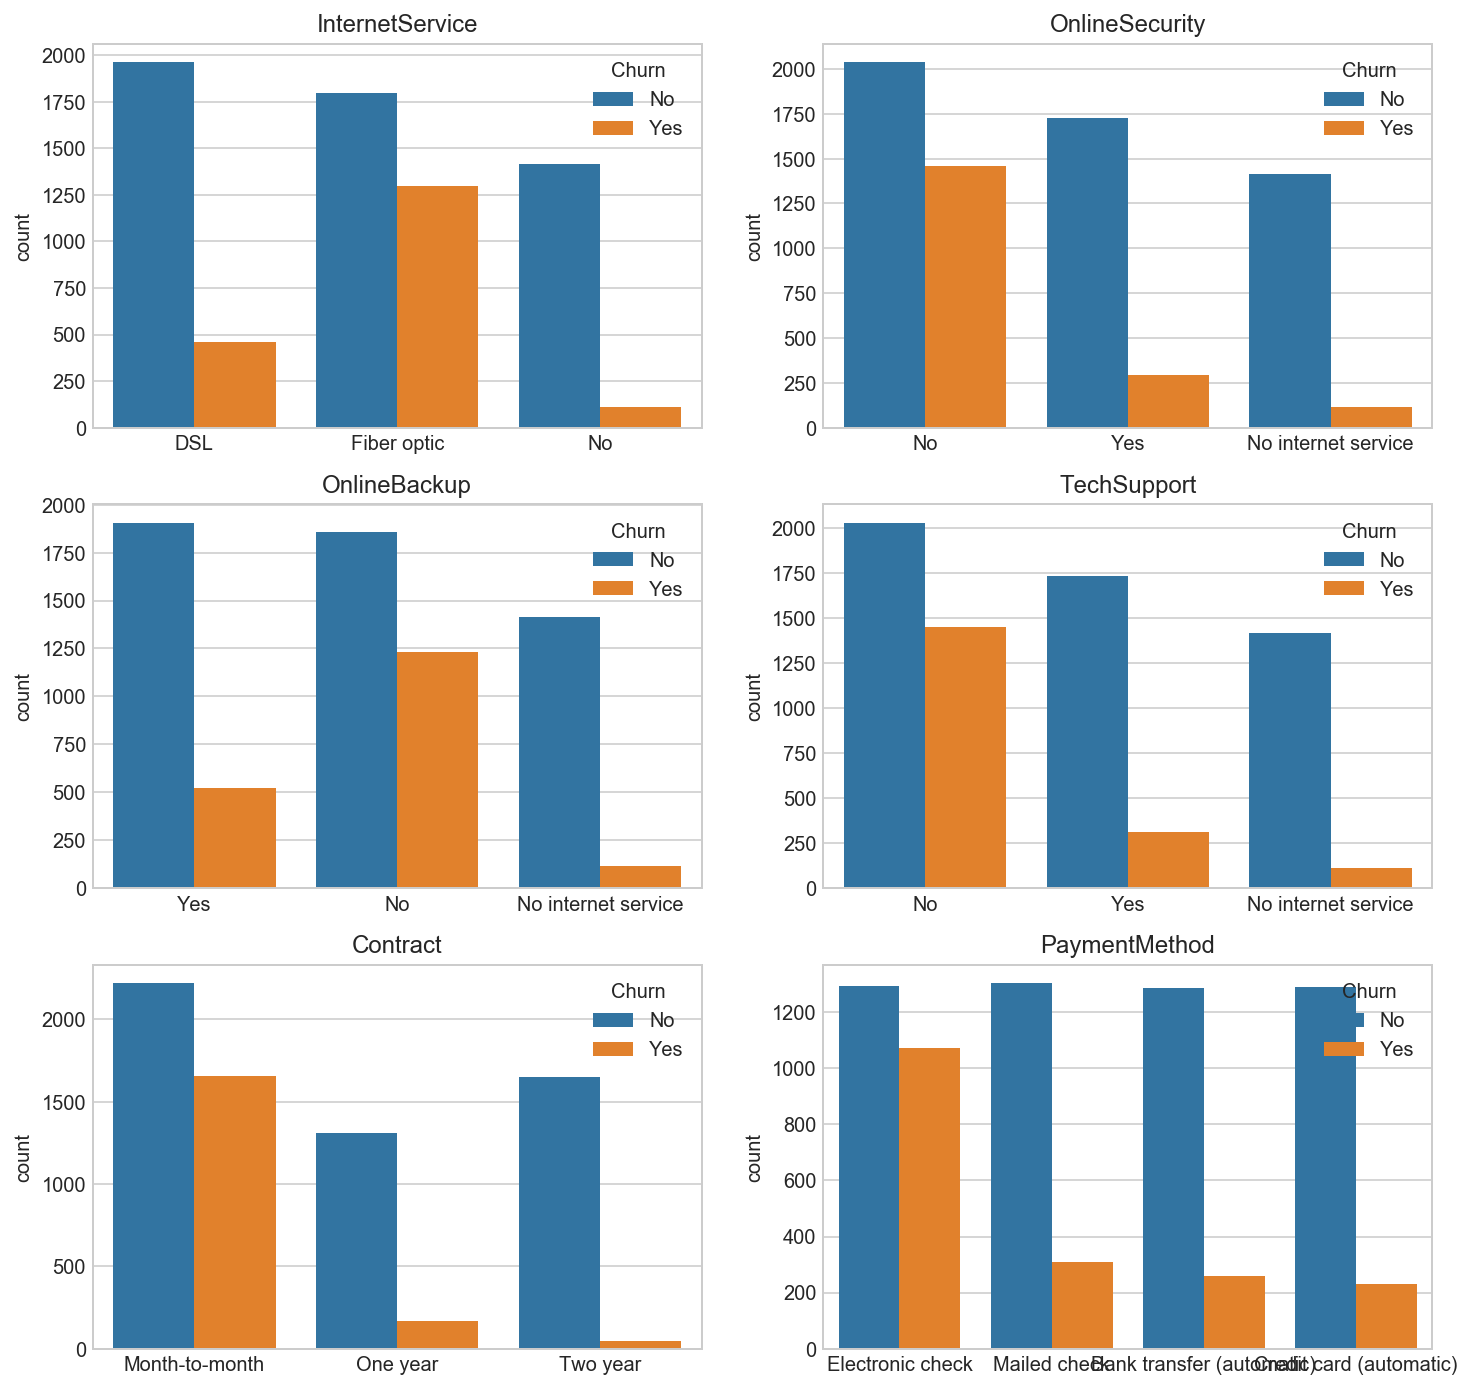

In [71]:
# Plot the features of interest
plt.figure(figsize=(12,12))
for i, col in enumerate(['InternetService','OnlineSecurity','OnlineBackup','TechSupport','Contract','PaymentMethod']):
    
    plt.subplot(3,2,i+1)
    sns.countplot(data=df, x=col, hue='Churn');
    plt.title(col);
    plt.xlabel('');

# Label Encoding and Feature Scaling

In [8]:
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder, StandardScaler

le = LabelEncoder()
scaler = StandardScaler()
binary_cols = []
num_cols = []

# Iterate through the numerical columns and scale
for col in df:
    if df[col].dtype == 'int' or df[col].dtype == 'float':

        num_cols.append(col)
        df[col] = scaler.fit_transform(df[[col]])
            
print(num_cols, "are scaled")


# Iterate through the binary categorical columns and encode
for col in df:
    if df[col].dtype == 'object':
        if df[col].nunique() == 2:
            
            binary_cols.append(col)
            df[col] = le.fit_transform(df[col])
            
print(binary_cols, "are label encoded")

['tenure', 'MonthlyCharges', 'TotalCharges'] are scaled
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'] are label encoded


In [9]:
X = pd.get_dummies(df.drop('Churn',axis=1))
y = df['Churn']

In [10]:
repeated_col = ['MultipleLines_No phone service','OnlineSecurity_No internet service',
                'OnlineBackup_No internet service','DeviceProtection_No internet service',
                'TechSupport_No internet service','StreamingTV_No internet service',
                'StreamingMovies_No internet service']
X.drop(repeated_col, axis=1, inplace=True)
X.TotalCharges.fillna(X.TotalCharges.median(), inplace=True)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,-1.277445,0,1,-1.160323,-0.994194,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0
5575-GNVDE,1,0,0,0,0.066327,1,0,-0.259629,-0.173740,1,0,1,0,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,0,0,0,1
3668-QPYBK,1,0,0,0,-1.236724,1,1,-0.362660,-0.959649,1,0,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1
7795-CFOCW,1,0,0,0,0.514251,0,0,-0.746535,-0.195248,0,0,1,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,0,0
9237-HQITU,0,0,0,0,-1.236724,1,1,0.197365,-0.940457,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0


In [11]:
# # Correlation Matrix for variables
# plt.figure(figsize=(12,10))
# sns.heatmap(X.corr(), cmap="seismic", vmin=-1, vmax=1);

# Model/Metrics Selection

In [12]:
def model_auc_pr(model, plot=False):
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

    # Train on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_proba = model.predict_proba(X_test)[:,1]
    
    # Get precision and recall values
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # calculate the precision-recall auc
    auc_score = auc(recall, precision)
    print(f'AUC for the PR curve is: {round(auc_score,4)}')
    
    if plot:
        # plot the ROC curve
        plt.figure(figsize=(6,6))
        plt.plot(precision, recall)
        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.title(f'Precision/Recall Curve AUC = {round(auc_score,4)}')
        plt.show()

In [13]:
%%time
rfc = RandomForestClassifier(n_estimators=100)
model_auc_pr(rfc)

AUC for the PR curve is: 0.6407
CPU times: user 578 ms, sys: 18.5 ms, total: 596 ms
Wall time: 605 ms


In [14]:
%%time
log_reg = LogisticRegression(solver='lbfgs')
model_auc_pr(log_reg)

AUC for the PR curve is: 0.6803
CPU times: user 130 ms, sys: 5.57 ms, total: 136 ms
Wall time: 78.8 ms


In [15]:
%%time
lgbm = LGBMClassifier()
model_auc_pr(lgbm)

AUC for the PR curve is: 0.6845
CPU times: user 560 ms, sys: 11.7 ms, total: 572 ms
Wall time: 161 ms


In [16]:
def model_f1_score(model, threshold):
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

    # Train on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = [1 if i > threshold else 0 for i in y_proba]
    return f1_score(y_test, y_pred)

In [17]:
f1_threshold = dict()

for threshold in np.linspace(0,1):
    
    f1_threshold[model_f1_score(lgbm, threshold)] = threshold

In [18]:
max_f1 = np.max(list(f1_threshold.keys()))
print(f'The highest F1 score is {max_f1}')
print(f'The corresponding threshold is {f1_threshold[max_f1]}')

The highest F1 score is 0.6516290726817042
The corresponding threshold is 0.3877551020408163


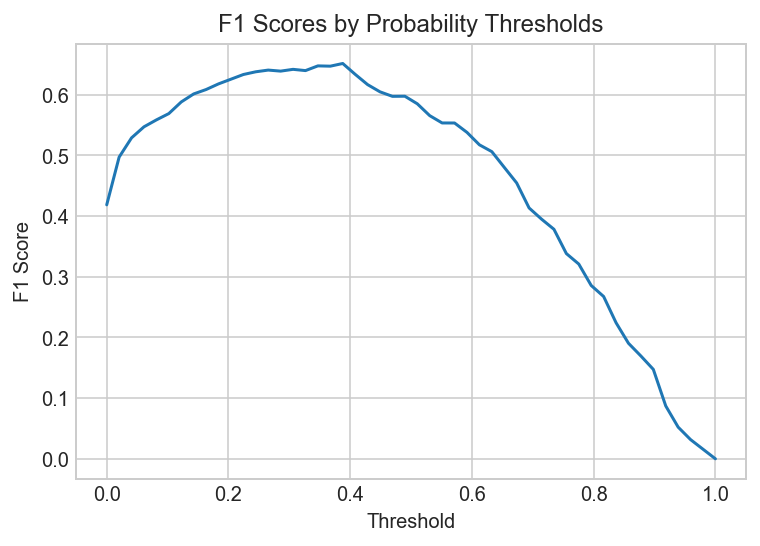

In [19]:
plt.plot(list(f1_threshold.values()),list(f1_threshold.keys()))
plt.title('F1 Scores by Probability Thresholds')
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.show()

# Model Evaluation

In [20]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Train on the training data
lgbm.fit(X_train, y_train)

# Make predictions on the test data
y_proba = lgbm.predict_proba(X_test)[:,1]
y_pred = [1 if i > 0.38 else 0 for i in y_proba]
f1_score(y_test, y_pred)

0.6500622665006226

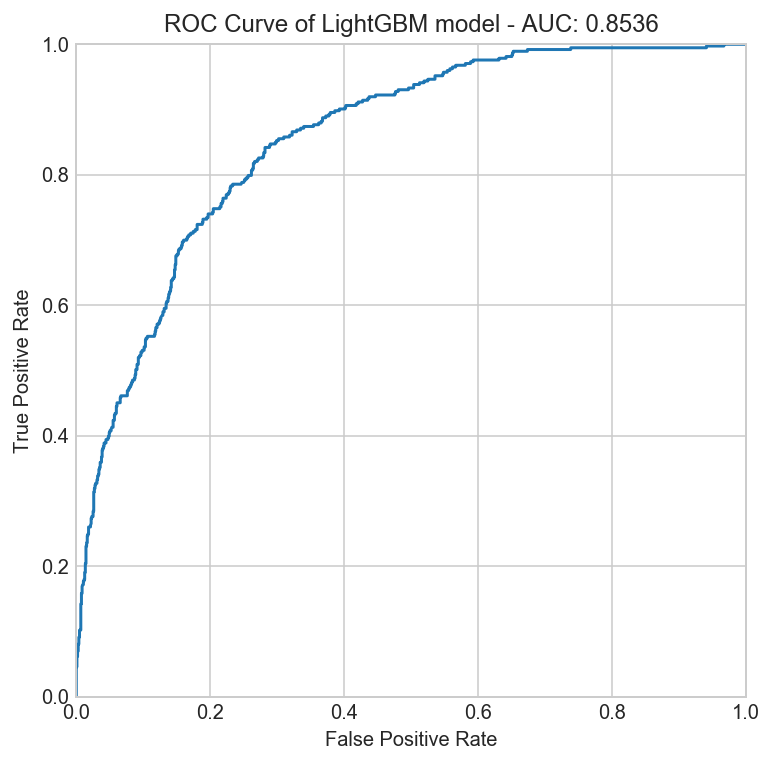

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title(f'ROC Curve of LightGBM model - AUC: {round(auc(fpr, tpr),4)}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

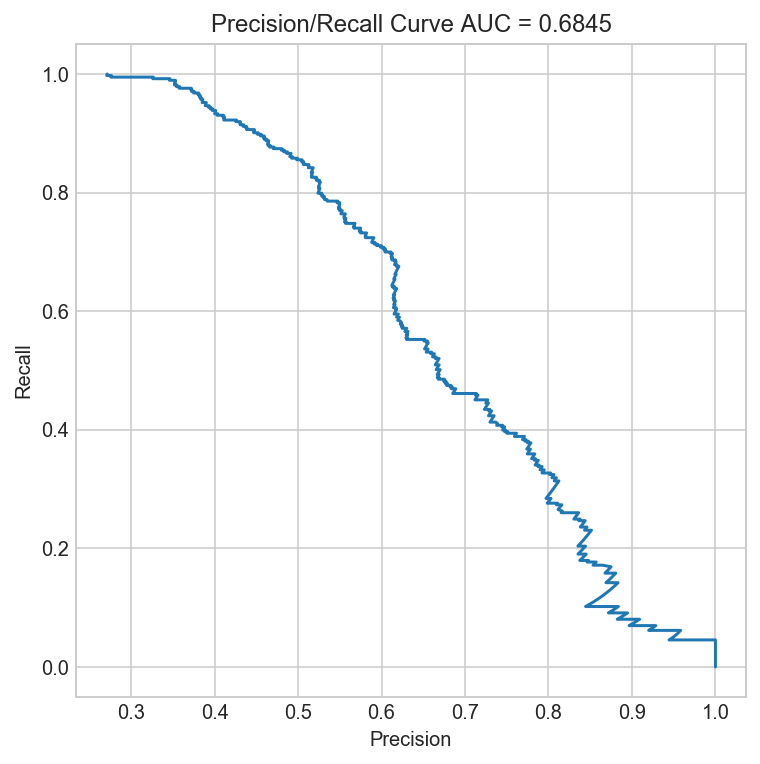

In [22]:
# Get precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# calculate the precision-recall auc
auc_score = auc(recall, precision)

# plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title(f'Precision/Recall Curve AUC = {round(auc_score,4)}')
plt.show()

In [59]:
lgbm_importance = pd.DataFrame(zip(X.columns, lgbm.feature_importances_), columns=['Feature','Value'])
lgbm_importance.sort_values('Value',inplace=True)

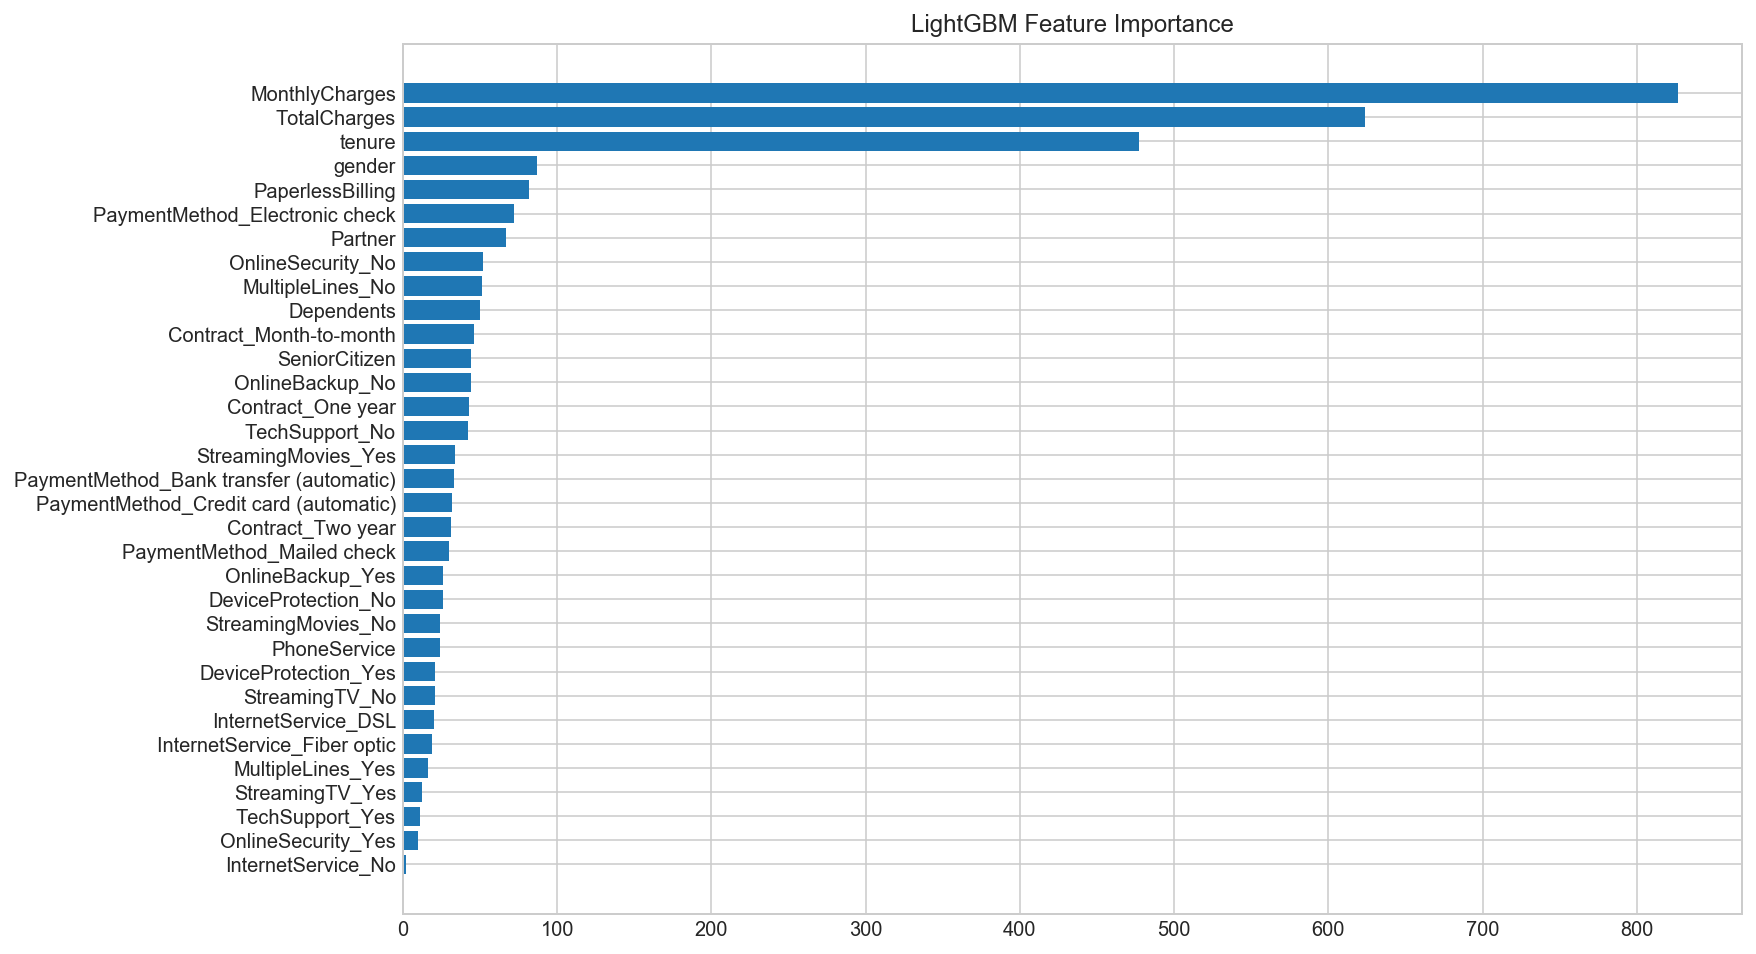

In [61]:
plt.figure(figsize=(12,8))
plt.barh(lgbm_importance.Feature, lgbm_importance.Value);
plt.title('LightGBM Feature Importance');